# Sequence Sensibility: LSTM for Dynamic Product Recommendations

## Libraries

In [65]:
import pandas as pd
import numpy as np
from numpy import array
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Data Study

In [3]:
data = pd.read_excel('Online Retail.xlsx')

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
data.isna().any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [7]:
data.dropna(inplace=True)

In [8]:
data[data.duplicated()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom


In [9]:
data = data[data['Quantity'] > 0]

## Explaratory Data Analysis (EDA)

Word clount analysis to identify frequently occuring terms in product descriptions

In [ ]:
text = ' '.join(data['Description'])
text

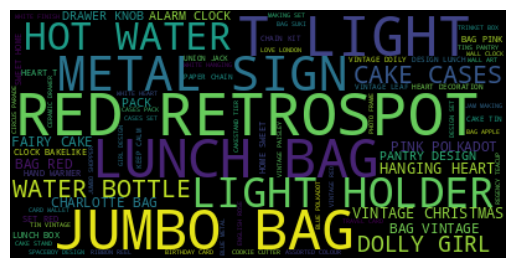

In [11]:
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

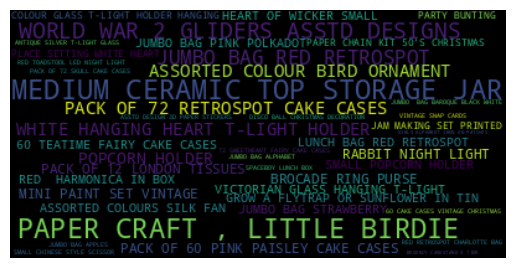

In [12]:
codeword_counts = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
wordcloud = WordCloud().generate_from_frequencies(codeword_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Count of products to assess inventory breadth

<Axes: xlabel='Description'>

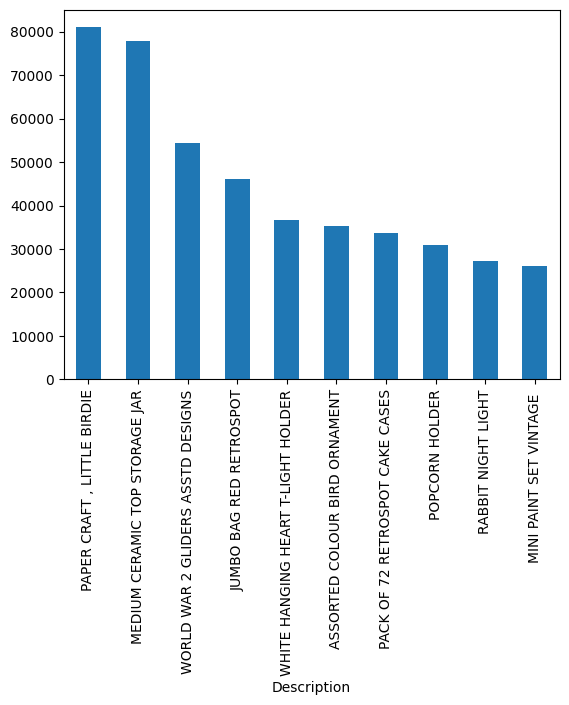

In [13]:
data.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10).plot(kind='bar')

Number of unique customers to understand the customer base

In [14]:
data['CustomerID'].nunique()

4339

Timeline charts to visualize transaction patterns over time

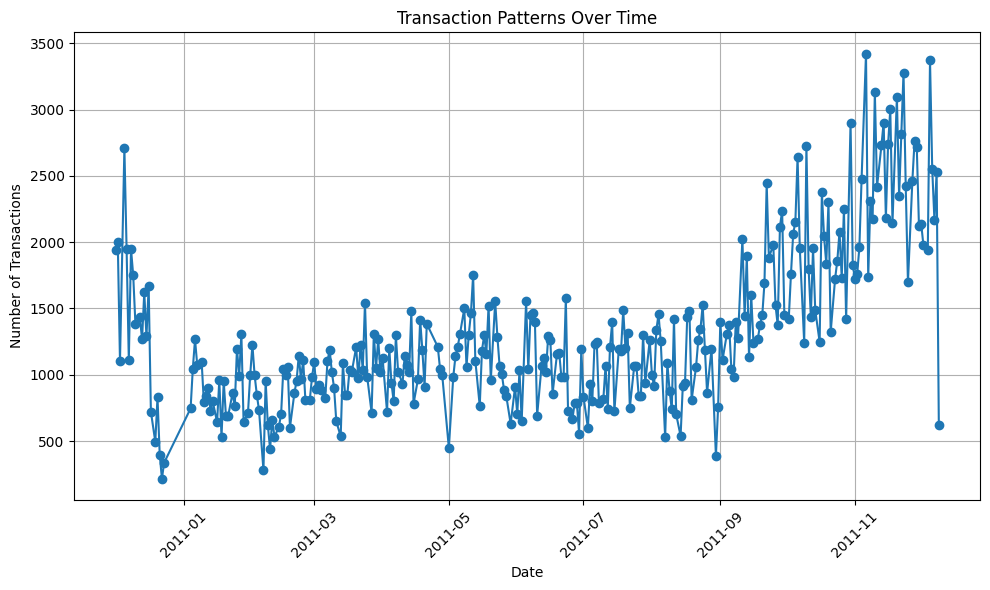

In [15]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])  # Convert InvoiceDate to datetime format

transaction_count = data.groupby(data['InvoiceDate'].dt.date).size()


plt.figure(figsize=(10, 6))
plt.plot(transaction_count.index, transaction_count.values, marker='o', linestyle='-')
plt.title('Transaction Patterns Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

## Initial Approach

### Data Pre-processing

In [16]:
df = data.copy()

In [17]:
df['Description'] = df['Description'].astype('str')

In [18]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [19]:
le = LabelEncoder()
df['Description_Encoded'] = le.fit_transform(df['Description'])

In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Description_Encoded
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,3698
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,3706
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,858
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,1804
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2763


In [21]:
df_grouped = df.groupby(['InvoiceDate', 'CustomerID', 'InvoiceNo'])['Description_Encoded'].apply(list).reset_index()

In [22]:
df_grouped.head()

,InvoiceDate,CustomerID,InvoiceNo,Description_Encoded
0,2010-12-01 08:26:00,17850.0,536365,"[3698, 3706, 858, 1804, 2763, 2964, 1435]"
1,2010-12-01 08:28:00,17850.0,536366,"[1553, 1550]"
2,2010-12-01 08:34:00,13047.0,536367,"[216, 2603, 2604, 1208, 1701, 523, 529, 528, 1..."
3,2010-12-01 08:34:00,13047.0,536368,"[1729, 2686, 3836, 413]"
4,2010-12-01 08:35:00,13047.0,536369,[281]


In [23]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for sequence in data:
        for i in range(len(sequence)):
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out

            if out_end_ix > len(sequence):
                break

            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            Y.append(seq_y)
    return X, Y

n_steps_in, n_steps_out = 3, 1
X, Y = create_sequences(df_grouped['Description_Encoded'].tolist(), n_steps_in, n_steps_out)

In [24]:
X = np.array(X)
X.shape

(345758, 3)

In [25]:
from tensorflow.keras.utils import to_categorical

y = np.array(Y).flatten()

num_classes = num_classes = np.max(y) + 1
Y_one_hot = to_categorical(y, num_classes=num_classes)
Y_one_hot.shape

(345758, 3877)

In [26]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(345758, 3, 1)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

### Model Architecture

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [29]:
N = df['Description'].nunique()
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(X.shape[1], 1), return_sequences=True, dropout=0.4, recurrent_dropout=0.2))
model.add(LSTM(100, activation='relu', dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(N, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 3877)              391577    
                                                                 
Total params: 512,777
Trainable params: 512,777
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
6483/6483 [==============================] - 64s 9ms/step - loss: 7.9221 - accuracy: 0.0047 - val_loss: 7.6071 - val_accuracy: 0.0046
Epoch 2/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.5451 - accuracy: 0.0047 - val_loss: 7.5311 - val_accuracy: 0.0046
Epoch 3/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.5048 - accuracy: 0.0048 - val_loss: 7.5213 - val_accuracy: 0.0046
Epoch 4/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.4976 - accuracy: 0.0047 - val_loss: 7.5206 - val_accuracy: 0.0046
Epoch 5/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.4967 - accuracy: 0.0047 - val_loss: 7.5212 - val_accuracy: 0.0046
Epoch 6/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.4940 - accuracy: 0.0047 - val_loss: 7.5220 - val_accuracy: 0.0046
Epoch 7/10
6483/6483 [==============================] - 57s 9ms/step - loss: 7.4948 - accuracy: 0.0047 - val_loss: 7.5230 - val_ac

In [31]:
scores = model.evaluate(X_test, Y_test, verbose=0)
scores

[7.519235134124756, 0.004743174649775028]

## Second Approach

In [32]:
df2 = data.copy()
df2 = df2[df2['Description'].map(df2['Description'].value_counts()) > 100]

df2['Description'].nunique()

1189

In [33]:
le = LabelEncoder()
df2['Description_Encoded'] = le.fit_transform(df2['Description'])

In [34]:
df2_grouped = df2.groupby(['InvoiceDate', 'CustomerID', 'InvoiceNo'])['Description_Encoded'].apply(list).reset_index()

In [35]:
def create_sequences(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for sequence in data:
        for i in range(len(sequence)):
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out

            if out_end_ix > len(sequence):
                break

            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            Y.append(seq_y)
    return X, Y

n_steps_in, n_steps_out = 3, 1
X, Y = create_sequences(df2_grouped['Description_Encoded'].tolist(), n_steps_in, n_steps_out)

In [36]:
X = np.array(X)
X.shape

(266540, 3)

In [37]:
from tensorflow.keras.utils import to_categorical

y = np.array(Y).flatten()

num_classes = num_classes = np.max(y) + 1
Y_one_hot = to_categorical(y, num_classes=num_classes)
Y_one_hot.shape

(266540, 1189)

In [38]:
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(266540, 3, 1)

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

### Model Architecture

In [40]:
N = df2['Description'].nunique()
model2 = Sequential()
model2.add(LSTM(100, activation='relu', input_shape=(X.shape[1], 1), return_sequences=True, dropout=0.4, recurrent_dropout=0.2))
model2.add(LSTM(100, activation='relu', dropout=0.4, recurrent_dropout=0.2))
model2.add(Dense(N, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 100)            40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1189)              120089    
                                                                 
Total params: 241,289
Trainable params: 241,289
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [41]:
model2.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val))

Epoch 1/10
4998/4998 [==============================] - 42s 8ms/step - loss: 6.9715 - accuracy: 0.0057 - val_loss: 6.8811 - val_accuracy: 0.0054
Epoch 2/10
4998/4998 [==============================] - 38s 8ms/step - loss: 6.8754 - accuracy: 0.0061 - val_loss: 6.8799 - val_accuracy: 0.0054
Epoch 3/10
4998/4998 [==============================] - 37s 7ms/step - loss: 6.8744 - accuracy: 0.0061 - val_loss: 6.8795 - val_accuracy: 0.0054
Epoch 4/10
4998/4998 [==============================] - 37s 7ms/step - loss: 6.8739 - accuracy: 0.0061 - val_loss: 6.8794 - val_accuracy: 0.0054
Epoch 5/10
4998/4998 [==============================] - 37s 7ms/step - loss: 6.8734 - accuracy: 0.0061 - val_loss: 6.8791 - val_accuracy: 0.0054
Epoch 6/10
4998/4998 [==============================] - 37s 7ms/step - loss: 6.8731 - accuracy: 0.0061 - val_loss: 6.8790 - val_accuracy: 0.0054
Epoch 7/10
4998/4998 [==============================] - 37s 7ms/step - loss: 6.8729 - accuracy: 0.0061 - val_loss: 6.8792 - val_ac

In [42]:
scores = model2.evaluate(X_test, Y_test, verbose=0)
scores

[6.879593372344971, 0.005571396555751562]

## Final Approach

### Data Pre=processing

In [43]:
df3 = data.copy()

In [44]:
description_data = df3[['Description']].dropna().drop_duplicates()
description_data

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.
...,...
527067,"LETTER ""W"" BLING KEY RING"
527069,"LETTER ""Z"" BLING KEY RING"
530382,PINK CRYSTAL SKULL PHONE CHARM
537621,CREAM HANGING HEART T-LIGHT HOLDER


In [ ]:
descriptions = description_data['Description'].tolist()
descriptions

In [47]:
import tensorflow_hub as hub
import tensorflow_text

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")

In [48]:
values = embed(descriptions)
values

<tf.Tensor: shape=(3877, 512), dtype=float32, numpy=
array([[-0.03049156,  0.06235193,  0.01420554, ..., -0.04859316,
         0.07428335,  0.05328113],
       [-0.00679109,  0.0289096 , -0.01599282, ..., -0.00808257,
         0.08752331, -0.02411547],
       [-0.01325122,  0.0269349 , -0.02804451, ..., -0.01312605,
         0.02256582,  0.03897539],
       ...,
       [-0.06929456,  0.06705685,  0.02140247, ..., -0.03581722,
         0.0219343 ,  0.05007144],
       [-0.02993876,  0.03511941,  0.01705818, ..., -0.04270473,
         0.03853655,  0.05111041],
       [ 0.03655951, -0.02627241,  0.05747497, ..., -0.09035098,
         0.06936757,  0.07293616]], dtype=float32)>

In [49]:
description_to_embedding = {desc: np.array(embedding) for desc, embedding in zip(descriptions, values)}

In [51]:
from sklearn.neighbors import NearestCentroid

encode = NearestCentroid()
encode.fit(values, descriptions)

NearestCentroid()

In [52]:
transactions = df3.groupby(['InvoiceDate', 'CustomerID', 'InvoiceNo'])['Description'].apply(list).reset_index()

In [53]:
def create_sequences(transactions, n_steps_in, n_steps_out, description_to_embedding):
    X, Y = [], []
    for sequence in transactions:
        for i in range(len(sequence)):
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out

            if out_end_ix > len(sequence):
                break

            # Convert descriptions to embeddings
            seq_x = [description_to_embedding[desc] for desc in sequence[i:end_ix]]
            seq_y = [description_to_embedding[desc] for desc in sequence[end_ix:out_end_ix]]

            # Since seq_x and seq_y are lists of embeddings, you need to handle them accordingly.
            # Depending on your model, you might want to average these embeddings or process them as sequences.
            X.append(seq_x)
            Y.append(seq_y)
    return X, Y

In [54]:
n_steps_in, n_steps_out = 3, 1
X, Y = create_sequences(transactions['Description'].tolist(), n_steps_in, n_steps_out, description_to_embedding)

In [55]:
X = np.array(X)
Y = np.array(Y)

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)

### Model Architecture

In [57]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping

In [58]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features), dropout=0.4, recurrent_dropout=0.2))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True, dropout=0.4, recurrent_dropout=0.2))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               245200    
                                                                 
 repeat_vector (RepeatVector  (None, 1, 100)           0         
 )                                                               
                                                                 
 lstm_5 (LSTM)               (None, 1, 100)            80400     
                                                                 
 time_distributed (TimeDistr  (None, 1, 512)           51712     
 ibuted)                                                         
                                                                 
Total params: 377,312
Trainable params: 377,312
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [59]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=100, validation_data=(X_val, Y_val), callbacks=[es])

Epoch 1/100
6483/6483 [==============================] - 51s 7ms/step - loss: 0.0012 - accuracy: 0.3928 - val_loss: 0.0012 - val_accuracy: 0.3962
Epoch 2/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3966 - val_loss: 0.0012 - val_accuracy: 0.3986
Epoch 3/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3981 - val_loss: 0.0012 - val_accuracy: 0.3986
Epoch 4/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3986 - val_loss: 0.0012 - val_accuracy: 0.3998
Epoch 5/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3987 - val_loss: 0.0012 - val_accuracy: 0.4000
Epoch 6/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3990 - val_loss: 0.0012 - val_accuracy: 0.4008
Epoch 7/100
6483/6483 [==============================] - 45s 7ms/step - loss: 0.0012 - accuracy: 0.3991 - val_loss: 0.0012 -

In [60]:
scores = model.evaluate(X_test, Y_test, verbose=1)
scores

2161/2161 [==============================] - 5s 2ms/step - loss: 0.0012 - accuracy: 0.3980


[0.0011554526863619685, 0.39800727367401123]

## Final Model Evaluation

### Validation Loss

In [61]:
Y_pred_prob = model.predict(X_test)

2161/2161 [==============================] - 5s 2ms/step


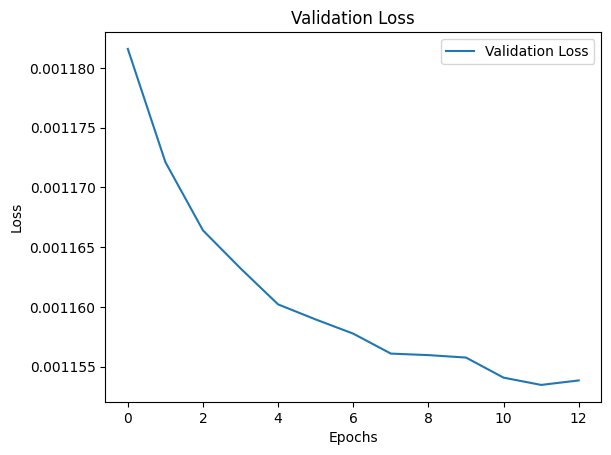

In [62]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()

### Validation Accuracy

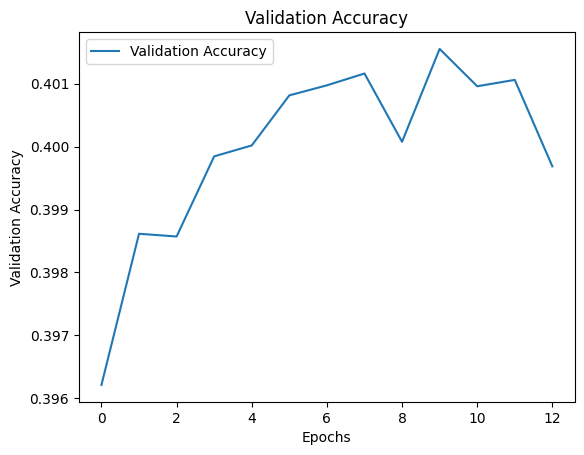

In [63]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Prediction

In [66]:
x_in = [['BABY BOOM RIBBONS ', 'GINGERBREAD MAN COOKIE CUTTER', 'ROSE COTTAGE KEEPSAKE BOX '],
        ['FELTCRAFT HAIRBAND PINK AND PURPLE', 'CERAMIC HEART FAIRY CAKE MONEY BANK', 'FAWN BLUE HOT WATER BOTTLE'],
        ['', '', 'JAM MAKING SET PRINTED']]

for data in x_in:
  x_input = array([embed(data)])
  x_input = x_input.reshape((1, n_steps_in, n_features))
  yhat = model.predict(x_input, verbose=0)
  print(f"{data} ----> {encode.predict(yhat[0,:])[0]}")

['BABY BOOM RIBBONS ', 'GINGERBREAD MAN COOKIE CUTTER', 'ROSE COTTAGE KEEPSAKE BOX '] ----> SKULLS STORAGE BOX LARGE
['FELTCRAFT HAIRBAND PINK AND PURPLE', 'CERAMIC HEART FAIRY CAKE MONEY BANK', 'FAWN BLUE HOT WATER BOTTLE'] ----> HOT WATER BOTTLE BABUSHKA LARGE
['', '', 'JAM MAKING SET PRINTED'] ----> STORAGE TIN VINTAGE LEAF
